In [1]:
!pip install mlxtend
!pip install apyori graphviz

  Preparing metadata (setup.py) ... done
  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5955 sha256=577b66e15531c79f6aa1400b12ba91d331107f9e897563f049ffb28a40c248cb
  Stored in directory: /root/.cache/pip/wheels/c4/1a/79/20f55c470a50bb3702a8cb7c94d8ada15573538c7f4baebe2d
Successfully built apyori


In [2]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpgrowth
import graphviz

In [3]:
#Create a sample dataset:
data = [['Milk', 'Bread', 'Butter'],
        ['Milk', 'Bread'],
        ['Milk', 'Eggs'],
        ['Bread', 'Eggs'],
        ['Milk', 'Bread', 'Eggs', 'Butter'],
        ['Tea', 'Bread', 'Eggs']]

df = pd.DataFrame(data, columns=['Item1', 'Item2', 'Item3', 'Item4'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
#Convert the dataset to a transaction format:
te = TransactionEncoder()
te_ary = te.fit(data).transform(data)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)
df_encoded

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Bread,Butter,Eggs,Milk,Tea
0,True,True,False,True,False
1,True,False,False,True,False
2,False,False,True,True,False
3,True,False,True,False,False
4,True,True,True,True,False
5,True,False,True,False,True


In [5]:
#Apply the Apriori algorithm:
frequent_itemsets_apriori = apriori(df_encoded, min_support=0.33, use_colnames=True)
frequent_itemsets_apriori

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,support,itemsets
0,0.833333,(Bread)
1,0.333333,(Butter)
2,0.666667,(Eggs)
3,0.666667,(Milk)
4,0.333333,"(Butter, Bread)"
5,0.500000,"(Bread, Eggs)"
6,0.500000,"(Bread, Milk)"
7,0.333333,"(Butter, Milk)"
8,0.333333,"(Eggs, Milk)"
9,0.333333,"(Butter, Bread, Milk)"


In [6]:
#Apply the FP-growth algorithm:
frequent_itemsets_fpgrowth = fpgrowth(df_encoded, min_support=0.33, use_colnames=True)
frequent_itemsets_fpgrowth

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,support,itemsets
0,0.833333,(Bread)
1,0.666667,(Milk)
2,0.333333,(Butter)
3,0.666667,(Eggs)
4,0.500000,"(Bread, Milk)"
5,0.333333,"(Butter, Milk)"
6,0.333333,"(Butter, Bread)"
7,0.333333,"(Butter, Bread, Milk)"
8,0.333333,"(Eggs, Milk)"
9,0.500000,"(Bread, Eggs)"


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


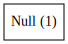

In [7]:
#Construction of FP-Tree
class Node:
    def __init__(self, item, count, parent):
        self.item = item
        self.count = count
        self.parent = parent
        self.children = {}

def build_tree(data, min_support):
    header_table = {}
    for index, row in data.iterrows():
        for item in row:
            header_table[item] = header_table.get(item, 0) + 1

    for k in list(header_table):
        if header_table[k] < min_support:
            del header_table[k]

    frequent_items = list(header_table.keys())
    frequent_items.sort(key=lambda x: header_table[x], reverse=True)

    root = Node("Null", 1, None)

    for index, row in data.iterrows():
        ordered_items = [item for item in frequent_items if item in row]
        if ordered_items:
            insert_tree(ordered_items, root, header_table, 1)

    # Ensure 'Null' is in header_table
    if 'Null' not in header_table:
        header_table['Null'] = (0, None)

    return root, header_table

def insert_tree(items, node, header_table, count):
    if not items:
        return

    if items[0] in node.children:
        node.children[items[0]].count += count
    else:
        node.children[items[0]] = Node(items[0], count, node)

        if header_table[items[0]][1] is None:
            header_table[items[0]] = (header_table[items[0]][0], node.children[items[0]])
        else:
            update_header(header_table[items[0]][1], node.children[items[0]])

    if len(items) > 1:
        insert_tree(items[1:], node.children[items[0]], header_table, count)

def update_header(node_to_test, target_node):
    while node_to_test.nodeLink is not None:
        node_to_test = node_to_test.nodeLink
    node_to_test.nodeLink = target_node

# FP-tree construction
root, header_table = build_tree(df, min_support=2)

# Visualize the FP-tree
def visualize_tree(node, graph, parent_name, graph_name):
    if node is not None:
        graph.node(graph_name, f"{node.item} ({node.count})", shape="box")
        if parent_name is not None:
            graph.edge(parent_name, graph_name)
        for child_key, child_node in node.children.items():
            visualize_tree(child_node, graph, graph_name, f"{graph_name}_{child_key}")

# Create a graph using Graphviz
fp_tree_graph = graphviz.Digraph('FP_Tree', node_attr={'shape': 'box'}, graph_attr={'rankdir': 'TB'})
visualize_tree(root, fp_tree_graph, None, 'Root')

# Display the FP-tree visualization
fp_tree_graph.render(filename='fp_tree_visualization', format='png', cleanup=True)
fp_tree_graph

In [8]:

#Answer the questions based on the FP-tree:
# a) Find maximum frequent itemset
max_frequent_itemset_fp = frequent_itemsets_fpgrowth[frequent_itemsets_fpgrowth['support'] == frequent_itemsets_fpgrowth['support'].max()]
print("a) Maximum Frequent Itemset (FP-growth):\n", max_frequent_itemset_fp)

max_frequent_itemset_apriori = frequent_itemsets_apriori[frequent_itemsets_apriori['support'] == frequent_itemsets_apriori['support'].max()]
print("a) Maximum Frequent Itemset (Apriori):\n", max_frequent_itemset_apriori)

a) Maximum Frequent Itemset (FP-growth):
     support itemsets
0  0.833333  (Bread)
a) Maximum Frequent Itemset (Apriori):
     support itemsets
0  0.833333  (Bread)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# b) How many transactions does it contain?
num_transactions = len(df)
print("b) Number of transactions in the dataset:", num_transactions)

b) Number of transactions in the dataset: 6


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
# c) Simulate frequent pattern enumeration based on the FP-tree constructed.
def mine_patterns(node, prefix, header_table, min_support, patterns):
    if header_table[node.item][0] >= min_support:
        patterns.append(prefix + [node.item])

    for child_key, child_node in node.children.items():
        mine_patterns(child_node, prefix + [node.item], header_table, min_support, patterns)


patterns_apriori = list(frequent_itemsets_apriori['itemsets'])
print("c) Frequent Patterns Enumerated (Apriori):\n", patterns_apriori)
patterns_fp = []
mine_patterns(root, [], header_table, min_support=2, patterns=patterns_fp)
print("c) Frequent Patterns Enumerated (FP-growth):\n", patterns_fp)

c) Frequent Patterns Enumerated (Apriori):
 [frozenset({'Bread'}), frozenset({'Butter'}), frozenset({'Eggs'}), frozenset({'Milk'}), frozenset({'Butter', 'Bread'}), frozenset({'Bread', 'Eggs'}), frozenset({'Bread', 'Milk'}), frozenset({'Butter', 'Milk'}), frozenset({'Eggs', 'Milk'}), frozenset({'Butter', 'Bread', 'Milk'})]
c) Frequent Patterns Enumerated (FP-growth):
 []


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


d) Give comparative analysis of this process with Apriori algorithm. FP-growth is generally more efficient than Apriori, especially with large datasets, as it avoids the candidate generation step. It constructs a compact tree structure, reducing the number of passes over the data compared to Apriori. The FP-tree also eliminates the need for candidate itemsets by using a conditional pattern base.

Comparative Analysis:

1. Code Simplicity: FP-growth (FP-tree): The FP-growth implementation is generally simpler and involves fewer steps. The key steps are building the FP-tree and mining patterns directly from it.

Apriori Algorithm: The Apriori algorithm involves multiple passes for candidate generation and pruning, making the code more complex.

2. Time Complexity: FP-growth (FP-tree): FP-growth is more time-efficient due to the reduced number of passes over the dataset and the avoidance of explicit candidate generation.

Apriori Algorithm: Apriori involves multiple passes, generating and pruning candidate itemsets at each pass, leading to higher time complexity.

3. Memory Usage: FP-growth (FP-tree): The FP-tree has a more compact representation, requiring less memory.

Apriori Algorithm: Requires additional memory to store candidate itemsets, potentially becoming memory-intensive for large datasets.

4. Candidate Generation: FP-growth (FP-tree): No explicit candidate generation step is needed, reducing computational overhead.

Apriori Algorithm: Requires multiple passes for candidate generation, making it computationally expensive.

5. Scalability: FP-growth (FP-tree): Scales well with larger datasets due to fewer passes and memory requirements.

Apriori Algorithm: May face scalability challenges, especially with a large number of transactions and items.

Conclusion: FP-growth (FP-tree) is generally preferred for its simplicity, time efficiency, and scalability, particularly with larger datasets.

The Apriori algorithm is still valuable, especially for educational purposes or when the dataset is not particularly large.

The choice between the two algorithms depends on factors such as dataset characteristics, implementation requirements, and available computational resources.